# This notebook shows how to build a simple emulator using ClimSim dataset

In [1]:
import gcsfs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# https://github.com/leap-stc/leap-stc.github.io/discussions/61
! mamba install -y -c nvidia cuda-nvcc pydot
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/srv/conda/envs/notebook'


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.1.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['cuda-nvcc', 'pydot']

[+] 0.0s
[+] 0.1s
nvidia/linux-64      ━━━━╸━━━━━━━━━━━━━━━╸━━   0.0 B /  ??

## [1] Load dataset

In [3]:
fs = gcsfs.GCSFileSystem()
print(fs.ls("gs://leap-persistent-ro/sungdukyu"))

# full dataset
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
ds_train_in = xr.open_dataset(mapper, engine='zarr', chunks={})
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds_train_out = xr.open_dataset(mapper, engine='zarr', chunks={})

# toy dataset
# For tutorial we are using a only first 10 days of the full dataset.
mapper = fs.get_mapper('leap-persistent/sungdukyu/toy_dataset/E3SM-MMF_ne4.train.input.tiny.zarr')
# ds_train_in.isel(sample=slice(0,72*10)).to_zarr(mapper, mode='w') # save
ds_train_in = xr.open_dataset(mapper, engine='zarr', chunks={})
mapper = fs.get_mapper('leap-persistent/sungdukyu/toy_dataset/E3SM-MMF_ne4.train.output.tiny.zarr')
# ds_train_out.isel(sample=slice(0,72*10)).to_zarr(mapper, mode='w') # save
ds_train_out = xr.open_dataset(mapper, engine='zarr', chunks={})

['leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr', 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.test.input.zarr', 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.test.output.zarr', 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr', 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr', 'leap-persistent-ro/sungdukyu/testing']


## [2] Determine in/out variables; subsampling

#### Mooers et al. (2021) 
- SPCAM5.0
- 1.9 x 2.5 FV (=13,824 grid cells)
- 10 years long (= 4,843,929,600 columns simulated)
- 10 days subsampling (484,392,960) c.f. our total sample ne4 = 210240 sample * 384 col/sample = 80,732,160 cols
- dt = 15 min
- CRM: 32km (4km/dx * 8dx)
- Each of the input variables was pre-normalized before exposure to the neural network by subtracting its respective mean and dividing by its respective range, with these statistics computed and applied separately for each vertical level in the case of the vertically resolved temperature and humidity profiles (Table 2). The reason we divide by the range instead of the more traditional standard deviation, in line with the methods of Rasp et al. (2018), is to avoid dividing by near-zero numbers, for example, in the case of stratospheric humidity.
- Some previous aqua-planet experiments also used the meridional wind vertical profile as part of the input vector to the neural network, but it was omitted in this case as preliminary neural network tests indicate it had an insignificant effect on the skill of the trained network


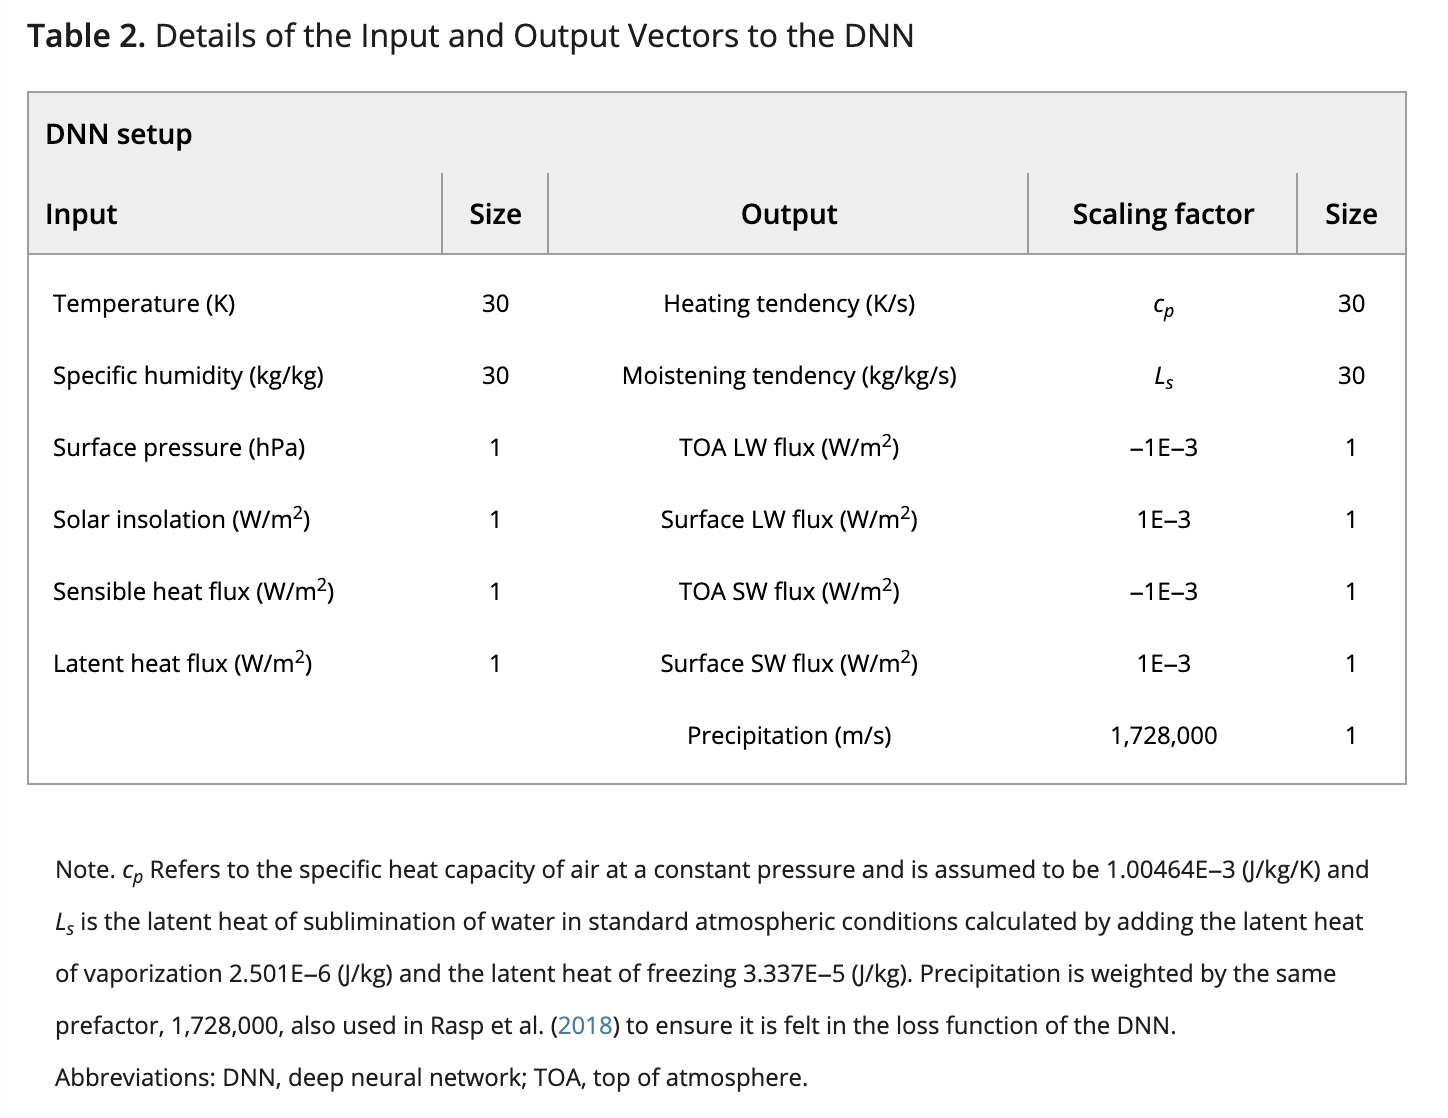<img src="Mooers_2021_variables.png"  width="70%">

From Mooers et al. 2021, https://doi.org/10.1029/2020MS002385

In [4]:
# in/out variable lists
vars_mli = ['state_t','state_q0001','state_ps','pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX',]
vars_mlo = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC','cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD']

In [5]:
# subset only input variables
mli = ds_train_in[vars_mli]

In [6]:
# caclulated output variables: ptend_t and ptend_q
# tendency = (output - input) / timestep
# the model time step was 1,2000 seconds
mlo = ds_train_out
mlo['ptend_t']     = (mlo['state_t'] - mli['state_t'])/1200 # T tendency [K/s]
mlo['ptend_q0001'] = (mlo['state_q0001'] - mli['state_q0001'])/1200 # Q tendency [kg/kg/s]

# now subet only output variables
mlo = mlo[vars_mlo]

### [3] Input / output normalization

Input normalization:\
X_normalized = (X - X_mean) / (X_max - X_min)

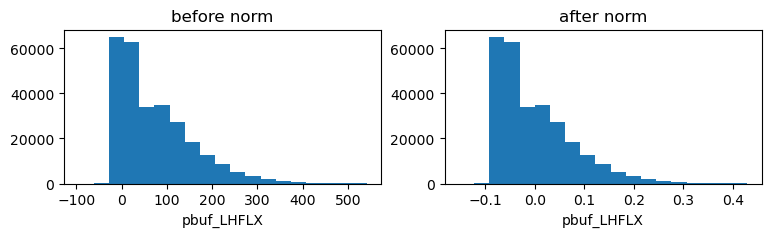

In [7]:
# load pre-saved normalization factors
mli_mean = xr.open_dataset('./norm_factors/mli_mean.nc')
mli_min = xr.open_dataset('./norm_factors/mli_min.nc')
mli_max = xr.open_dataset('./norm_factors/mli_max.nc')

# plot just for demonstration purpose
plotvar = 'pbuf_LHFLX'
fig, _ax = plt.subplots(ncols=2)
ax=_ax[0]
plotdata = mli[plotvar]
plotdata.plot.hist(bins=19, ax=ax);
ax.set_title('before norm')
ax=_ax[1]
plotdata = (mli[plotvar] - mli_mean[plotvar]) / (mli_max[plotvar] - mli_min[plotvar])
plotdata.plot.hist(bins=19, ax=ax);
ax.set_title('after norm')
fig.set_size_inches(9,2)

# Normalize input
mli = (mli - mli_mean) / (mli_max - mli_min)

Output scaling:\
Y_scaled = Y * scale_factor 

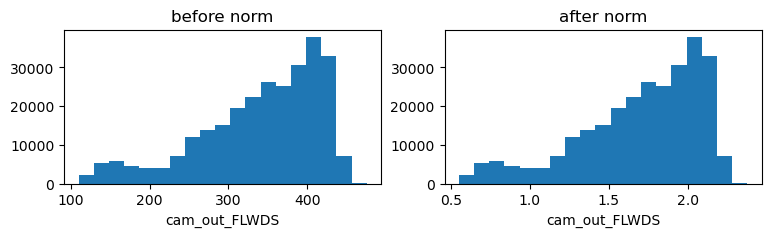

In [8]:
# load pre-saved scale factors
mlo_scale = xr.open_dataset('./norm_factors/mlo_scale.nc', engine='netcdf4')

# plot just for demonstration purpose
plotvar = 'cam_out_FLWDS'
fig, _ax = plt.subplots(ncols=2)
ax=_ax[0]
plotdata = mlo[plotvar]
plotdata.plot.hist(bins=19, ax=ax);
ax.set_title('before norm')
ax=_ax[1]
plotdata = mlo[plotvar] * mlo_scale[plotvar]
plotdata.plot.hist(bins=19, ax=ax);
ax.set_title('after norm')
fig.set_size_inches(9,2)

# Scale output
mlo = mlo * mlo_scale

In [9]:
# now dataset has 3 dims
# since we are treating each column as an indepedent sample,
# we want to flatten "sample" and "ncol" into a "batch dimension"
mli.dims

Frozen({'sample': 720, 'lev': 60, 'ncol': 384})

In [10]:
# make a batch dimension.
mli = mli.stack({'batch':{'sample','ncol'}})
mlo = mlo.stack({'batch':{'sample','ncol'}})

# y_train = mlo.stack({'batch':{'sample','ncol'}})
# x_val = x_val.stack({'batch':{'sample','ncol'}})
# y_val = y_val.stack({'batch':{'sample','ncol'}})
# x_train

In [11]:
# now, our dataset has 2 dims.
mli.dims

Frozen({'lev': 60, 'batch': 276480})

In [12]:
# However, for both mli and mlo stores each variable separately. 
# So, the dataset is not ML ready yet.
mli

<xarray.Dataset>
Dimensions:      (lev: 60, batch: 276480)
Coordinates:
  * batch        (batch) object MultiIndex
  * sample       (batch) int64 0 0 0 0 0 0 0 0 ... 719 719 719 719 719 719 719
  * ncol         (batch) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
Dimensions without coordinates: lev
Data variables:
    state_t      (lev, batch) float64 dask.array<chunksize=(60, 276480), meta=np.ndarray>
    state_q0001  (lev, batch) float64 dask.array<chunksize=(60, 276480), meta=np.ndarray>
    state_ps     (batch) float64 dask.array<chunksize=(276480,), meta=np.ndarray>
    pbuf_SOLIN   (batch) float64 dask.array<chunksize=(276480,), meta=np.ndarray>
    pbuf_LHFLX   (batch) float64 dask.array<chunksize=(276480,), meta=np.ndarray>
    pbuf_SHFLX   (batch) float64 dask.array<chunksize=(276480,), meta=np.ndarray>

In [13]:
# We want to pack all variables into one long array for each sample.
# e.g., X = X[state_t[0], state_t[1], ..., state_t[59], state_q[0], state_q[1], ..., state_q[59], state_ps, pbuf_SOLIN, pbuf_LHFLX, pbuf_SHFLX]
# (likewise for ML output)
mli = mli.to_stacked_array("mlvar", sample_dims=["batch"], name='mli')
mlo = mlo.to_stacked_array("mlvar", sample_dims=["batch"], name='mlo')

In [14]:
# now, both mli and mlo are ready for ML!
# look at the "mlvar", which is the dimension for stacked variables, has a correct length of input (124)
print(mli.shape)
print(mlo.shape)

(276480, 124)
(276480, 128)


In [15]:
# converting xarray DataArray to Numpy array for machine learning (can't feed xarray dataset to tensorflow yet)
mli = mli.values
mlo = mlo.values

In [16]:
# Now, we want to split dataset into train and validation sets.
# before splitting, shuffling along batch dimension is a good idea.
idx = np.arange(mli.shape[0])
idx = np.random.permutation(idx) # an array of randomly ordered indices
mli = mli[idx,:]
mlo = mlo[idx,:]

In [17]:
# split train vs validation
split = .9

N = mli.shape[0]
ind_split = int(N*split)

x_train = mli[:ind_split, :]
y_train = mlo[:ind_split, :]
x_val   = mli[ind_split:, :]
y_val   = mlo[ind_split:, :]

In [18]:
# now, datasets are really ready for training.
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(248832, 124)
(248832, 128)
(27648, 124)
(27648, 128)


### [4] build model

In [25]:
import tensorflow as tf
import tensorflow.keras as keras

# check if GPUs are available
gpu = tf.config.list_physical_devices('GPU') 
print(gpu)
# # prevent GPU memory preallocation
# tf.config.experimental.set_memory_growth(gpu[0], True) 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [26]:
# Set the input and output size
input_length = 124        # 2 variables with a length 60 + 4 variables with a length 1
output_length_lin  = 2*60 # 2 output variables with a length 60
output_length_relu = 8    # 8 output variables with a length 1
output_length = output_length_lin + output_length_relu

# set hyperparameters
# the number of hidden layers are arbitrarily chosen. Here, 3.
n_nodes     = 256    # number of nodes per layer
act         = 'ReLU'  # activation function
batch_size  = 192    # batch size
optimizer   = keras.optimizers.Adam()

# constrcut a model
input_layer    = keras.layers.Input(shape=(input_length,), name='input')               # input layer
hidden_0       = keras.layers.Dense(n_nodes, activation=act)(input_layer)              # hidden layer 1 (nodes = n_nodes)
hidden_1       = keras.layers.Dense(n_nodes, activation=act)(hidden_0)                 # hidden layer 2 (nodes = n_nodes)
output_pre     = keras.layers.Dense(n_nodes, activation=act)(hidden_1)                 # hidden layer 3 (nodes = n_nodes)
output_lin     = keras.layers.Dense(output_length_lin,activation='linear')(output_pre) # output layer A (without activation)
output_relu    = keras.layers.Dense(output_length_relu,activation='relu')(output_pre)  # output layer B (with ReLU activation)
output_layer   = keras.layers.Concatenate()([output_lin, output_relu])                 # concatenating output layers A and B

model = keras.Model(input_layer, output_layer, name='Emulator')

model.summary()

# compile
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=['mse','mae','accuracy'])

Model: "Emulator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 124)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          32000       ['input[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 256)          65792       ['dense_1[0][0]']                
                                                                                           

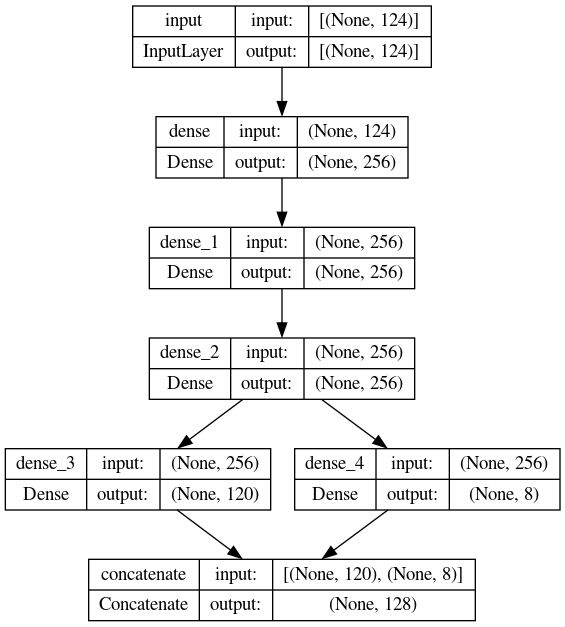

In [27]:
fn_model_diagram = './my_model.png'
keras.utils.plot_model(model, to_file=fn_model_diagram, show_shapes=True)

In [28]:
# Now, time to train!
N_epochs = 100
history = model.fit(x_train,y_train,
                    validation_data=(x_val, y_val),
                    batch_size= batch_size,
                    epochs = N_epochs)

Epoch 1/100
1296/1296 [==============================] - 6s 3ms/step - loss: 0.0081 - mse: 0.0081 - mae: 0.0309 - accuracy: 0.9551 - val_loss: 0.0075 - val_mse: 0.0075 - val_mae: 0.0279 - val_accuracy: 0.9641
Epoch 2/100
1296/1296 [==============================] - 4s 3ms/step - loss: 0.0074 - mse: 0.0074 - mae: 0.0273 - accuracy: 0.9631 - val_loss: 0.0073 - val_mse: 0.0073 - val_mae: 0.0264 - val_accuracy: 0.9669
Epoch 3/100
1296/1296 [==============================] - 4s 3ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0262 - accuracy: 0.9655 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0262 - val_accuracy: 0.9676
Epoch 4/100
1296/1296 [==============================] - 4s 3ms/step - loss: 0.0071 - mse: 0.0071 - mae: 0.0254 - accuracy: 0.9667 - val_loss: 0.0071 - val_mse: 0.0071 - val_mae: 0.0249 - val_accuracy: 0.9700
Epoch 5/100
1296/1296 [==============================] - 4s 3ms/step - loss: 0.0070 - mse: 0.0070 - mae: 0.0249 - accuracy: 0.9677 - val_loss: 0.0070 - val_mse: 0.0

In [29]:
# see what kind of metrics are stored in 'history'
print(history.history.keys())

dict_keys(['loss', 'mse', 'mae', 'accuracy', 'val_loss', 'val_mse', 'val_mae', 'val_accuracy'])


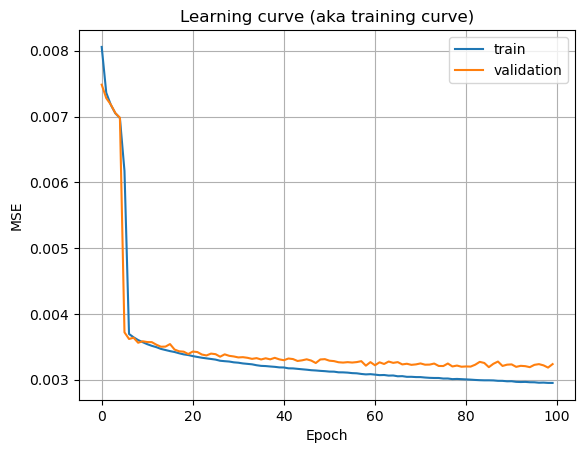

In [30]:
fig, ax = plt.subplots()
ax.plot(history.history['mse'], label='train')
ax.plot(history.history['val_mse'], label='validation')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.set_title('Learning curve (aka training curve)')
ax.legend()
ax.grid()

In [24]:
# if you want to build and train another model, you may need to clear GPU memory first.
import gc
del model 
tf.keras.backend.clear_session()
gc.collect()

1170

#### What else needs to be done
- stop at the epoch of the minimum loss, using both training + validation dataset.
- Evaluation using test dataset.
  - leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.test.input.zarr
  - leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.test.output.zarr